In [ ]:
import torch

# Check if CUDA is available
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')

torch.set_default_device(device)
print(f"Using device = {torch.get_default_device()}")

Using device = cpu


In [ ]:
import string
import unicodedata

allowed_characters = string.ascii_letters + " .,;'" + "_"
n_letters = len(allowed_characters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in allowed_characters
    )

In [ ]:
# Find letter index from all_letters
def letterToIndex(letter):
    if letter not in allowed_characters:
        return allowed_characters.find("_")
    else:
        return allowed_characters.find(letter)

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

In [ ]:
from io import open
import glob
import os
import time
import torch
from torch.utils.data import Dataset

class NamesDataset(Dataset):

  def __init__(self, data_dir):
    self.data_dir = data_dir
    self.load_time = time.localtime
    labels_set =  set()

    self.data = []
    self.data_tensors = []
    self.labels = []
    self.labels_tensors = []

    text_files = glob.glob(os.path.join(data_dir, "*.txt"))
    for filename in text_files:
      label = os.path.splitext(os.path.basename(filename))[0]
      labels_set.add(label)
      lines = open(filename, encoding='utf-8').read().strip().split('\n')
      for name in lines:
        self.data.append(name)
        self.data_tensors.append(lineToTensor(name))
        self.labels.append(label)

    self.labels_unique = list(labels_set)
    for idx in range(len(self.labels)):
        temp_tensor = torch.tensor([self.labels_unique.index(self.labels[idx])], dtype = torch.long)
        self.labels_tensors.append(temp_tensor)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    data_item = self.data[idx]
    data_label = self.labels[idx]
    data_tensor = self.data_tensors[idx]
    label_tensor = self.labels_tensors[idx]

    return label_tensor, data_tensor, data_label, data_item



In [ ]:
from zipfile import ZipFile
file_name = "/content/data.zip"

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
alldata = NamesDataset("data/names")
print(f"loaded {len(alldata)} items of data")
print(f"example = {alldata[0]}")

loaded 20074 items of data
example = (tensor([5]), tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0.]]]), 'Czech', 'Abl')


In [ ]:
train_set, test_set = torch.utils.data.random_split(alldata, [.85, .15], generator = torch.Generator(device=device).manual_seed(2024))
print(len(train_set))
print(len(test_set))

17063
3011


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CharRNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(CharRNN, self).__init__()

    self.rnn = nn.RNN(input_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=1)

  def forward(self, line_tensor):
    rnn_out, hidden = self.rnn(line_tensor)
    output = self.h2o(hidden[0])
    output = self.softmax(output)
    return output


In [ ]:
n_hidden = 128
rnn = CharRNN(n_letters, n_hidden, len(alldata.labels_unique))
print(rnn)

CharRNN(
  (rnn): RNN(58, 128)
  (h2o): Linear(in_features=128, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [ ]:
def label_from_output(output, output_labels):
    top_n, top_i = output.topk(1)
    label_i = top_i[0].item()
    return output_labels[label_i], label_i

input_example = lineToTensor('Albert')
output = rnn(input_example) #this is equivalent to ``output = rnn.forward(input)``
print(output)
print(label_from_output(output, alldata.labels_unique))

tensor([[-2.8824, -2.8596, -2.9310, -2.7350, -2.9266, -3.0337, -2.8951, -2.8145,
         -2.8973, -2.8312, -2.7965, -2.9699, -2.8725, -2.8660, -3.0098, -2.9881,
         -2.9370, -2.8322]], grad_fn=<LogSoftmaxBackward0>)
('Spanish', 3)


In [ ]:
# train

import random
import numpy as np

def train(rnn, training_data, n_epoch, n_batch_size = 64, report_every = 50, learning_rate = 0.2, criterion = nn.NLLLoss()):
  current_loss = 0
  all_losses = []

  rnn.train()
  optimizer = torch.optim.SGD(rnn.parameters(), lr = learning_rate)


  for iter in range(1, n_epoch + 1):
    rnn.zero_grad()

    batches = list(range(len(training_data)))
    random.shuffle(batches)
    batches = np.array_split(batches, len(batches)//n_batch_size)

    for idx, batch in enumerate(batches):
      batch_loss = 0
      for i in batch:
        (label_tensor, text_tensor, label, text) = training_data[i]
        output = rnn.forward(text_tensor)
        loss = criterion(output, label_tensor)
        batch_loss += loss

      batch_loss.backward()
      nn.utils.clip_grad_norm_(rnn.parameters(), 3)
      optimizer.step()
      optimizer.zero_grad()

      # average loss per example in batch
      current_loss += batch_loss.item()/len(batch)

    # average loss per batch
    all_losses.append(current_loss/ len(batches))

    if iter % report_every == 0:
      print(f"{iter} ({iter / n_epoch:.0%}): \t average batch loss = {all_losses[-1]}")
    current_loss = 0

  return all_losses

In [ ]:
all_losses = train(rnn, train_set, n_epoch=30, learning_rate=0.15, report_every=5)


5 (17%): 	 average batch loss = 0.8797391582735017
10 (33%): 	 average batch loss = 0.6948055596245445
15 (50%): 	 average batch loss = 0.5820632602780317
20 (67%): 	 average batch loss = 0.49811922203449926
25 (83%): 	 average batch loss = 0.4345291968506151
30 (100%): 	 average batch loss = 0.39947933712968803


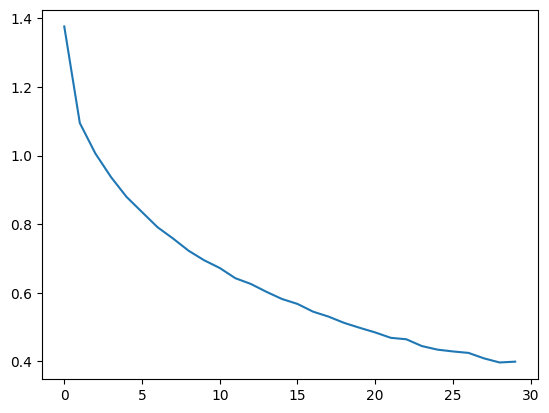

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

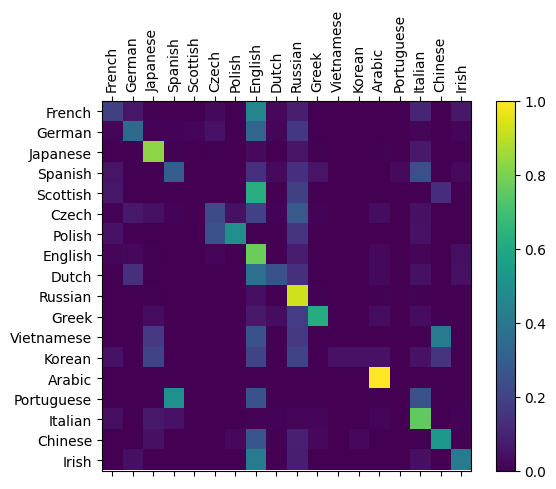

In [ ]:
def evaluate(rnn, testing_data, classes):
    confusion = torch.zeros(len(classes), len(classes))

    rnn.eval() #set to eval mode
    with torch.no_grad(): # do not record the gradients during eval phase
        for i in range(len(testing_data)):
            (label_tensor, text_tensor, label, text) = testing_data[i]
            output = rnn(text_tensor)
            guess, guess_i = label_from_output(output, classes)
            label_i = classes.index(label)
            confusion[label_i][guess_i] += 1

    # Normalize by dividing every row by its sum
    for i in range(len(classes)):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion.cpu().numpy()) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticks(np.arange(len(classes)), labels=classes, rotation=90)
    ax.set_yticks(np.arange(len(classes)), labels=classes)

    # Force label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()



evaluate(rnn, test_set, classes=alldata.labels_unique)

In [ ]:
def predict(rnn, input_line, classes):
    print(f"\n> {input_line}")

    rnn.eval()
    with torch.no_grad():
        line_tensor = lineToTensor(input_line)
        output = rnn(line_tensor)
        guess, guess_i = label_from_output(output, classes)
        print(guess)


while True:
    sentence = input("Input:")
    if sentence == "quit":
        break

    predict(rnn, sentence, classes=alldata.labels_unique)


Input:Althuis

> Althuis
Greek
Input:Amstel

> Amstel
Dutch
Input:Asghar

> Asghar
Arabic
Input:Maalouf

> Maalouf
Arabic
Input:Abaleshev

> Abaleshev
Russian
Input:Albuquerque

> Albuquerque
Italian
Input:Albuquerque

> Albuquerque
Italian
Input:Alfaro

> Alfaro
Italian
Input:Crespo

> Crespo
Italian
Input:Esparza

> Esparza
Spanish
Input:quit
